用這些資料來預測20日~月底的每小時腳踏車租借數量。

透過這些預測模型，租借腳踏車的公司就可以使用動態定價(像是Uber動態價格)來獲取更多的利益，或是準備更多的腳踏車以滿足臨時大量需求

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [71]:
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.ensemble import RandomForestRegressor

In [52]:
fig = plt.figure()
sns.set()

<Figure size 640x480 with 0 Axes>

In [11]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


資料欄位
 (1) datetime：日期，以年-月-日小時的形式給出。 

 (2) season：季節。1 為春季, 2為夏季,3 為秋季,4 為冬季。

 (3) hodliday：是否為假期。1代表是，0代表不是。 

 (4) workingday：是否為工作日，1代表是，0代表不是。 

 (5) weather:天氣： 

    1: 天氣晴朗或少雲/部有雲。 

    2: 有霧和雲/風等。 

    3: 小雪/小雨，閃電及多雲。

    4: 大雨/冰雹/閃電和大霧/大雪。

(6) temp - 攝氏溫度。 

(7) atemp - 人們所感受到的溫度。 

(8) humidity - 濕度。 

(9) windspeed - 風速。 

(10) casual -隨機預定自行車的人數 

(11) registered - 登記預定自行車的人數。 

(12) count - 總租車數，即casual+registered數目。 

其中10~12不屬於特徵，12為我們需要預測的值。

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
#資料分布
train_df.describe()

#發現最後右邊的欄位count中的50百分位數為145, 75百分位數為284以及 max值為977相差非常巨大，因此可以判斷有Outlier(異常值)，
#可以使用最簡單的'超出三倍標準差概念'將這些Outlier先去掉，避免對Model造成影響，去掉Outlier之後的預測分數也會明顯提升

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
#去掉 Outlier 異常值
print('還沒去掉:', train_df.shape)
train_df = train_df[np.abs(train_df['count']-train_df['count'].mean() )<= (3*train_df['count'].std())]
print('已去掉:', train_df.shape)

還沒去掉: (10886, 12)
已去掉: (10739, 12)


In [9]:
train_df.isna().sum()

#沒有缺失值

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [46]:
#接下來要將時間處理成讓Random fo
#rest可以分析的格式,由於Train跟Test的資料都要做這樣的處理，因此我們先把Train, Test Data合併後一起處理
data = pd.concat([train_df,test_df])

data.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0


In [73]:
#資料欄位處理 主要透過pandas將日期劃分為month/day/time
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['hour'] = pd.DatetimeIndex(data['datetime']).hour
data['year'] = pd.DatetimeIndex(data['datetime']).year

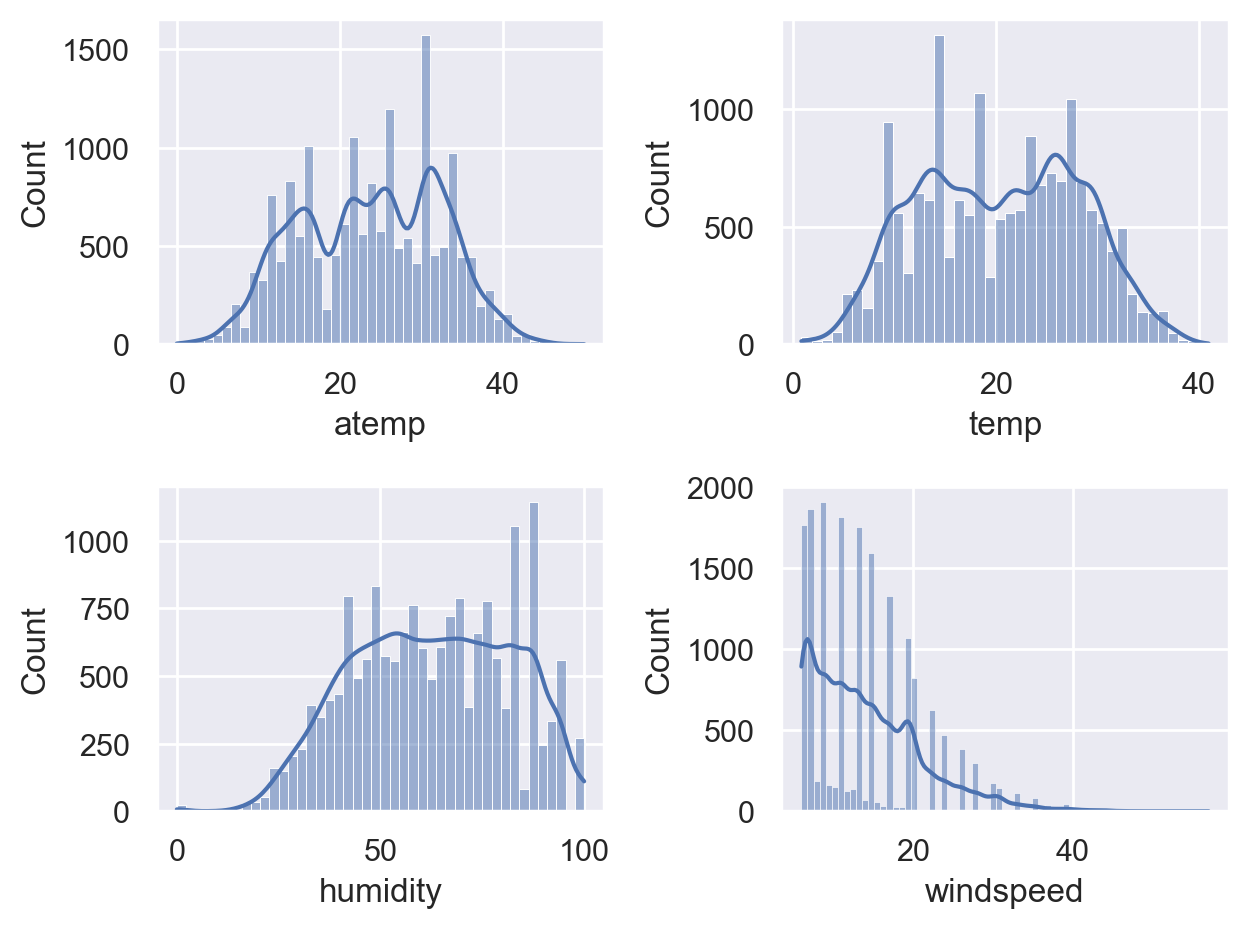

In [85]:
#溫度(temp)、體感溫度(atemp)、濕度(humidity)、風速(windspeed)的4個資料分佈情況
fig,axes = plt.subplots(2,2)

sns.histplot(data['atemp'], kde=True, ax=axes[0,0])
sns.histplot(data['temp'], kde=True, ax=axes[0,1])
sns.histplot(data['humidity'], kde=True, ax=axes[1,0])
sns.histplot(data['windspeed'], kde=True, ax=axes[1,1])

plt.tight_layout()

下方四張圖裡面我們可以觀察到一個非常重要的關鍵！在右下方風速的圖可以發現風速為0的值非常多，
而靠近0的(大約風速6,7以內都沒有出現)，中間也出現許多沒有任何值的情況，

因此可以大概推論風速0是風速太小量不到,或是只要是風速為空值都被資料提供方補上0！
這種的0會對大部分的模型造成預估失準，
因此我們要將風速為0的值重新估計

In [69]:
data['windspeed'].describe()

count    17379.000000
mean        12.736540
std          8.196795
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

我們先將資料分成風速為0以及風速不為0的資料，並且用風速不為0的資料來訓練random forest的模型，
將訓練好的模型,來預估風速為0的風速到底是多少。
我們將風速為0的資料重新預估後去填補了空隙，這樣的做法可以明顯提升預測的準度

In [76]:
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0.loc[:,"windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

C:\Users\znzn8\AppData\Local\Temp\ipykernel_66104\1443828564.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0.loc[:,"windspeed"] = wind0Values
C:\Users\znzn8\AppData\Local\Temp\ipykernel_66104\1443828564.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = dataWindNot0.append(dataWind0)


<Axes: xlabel='windspeed', ylabel='Count'>

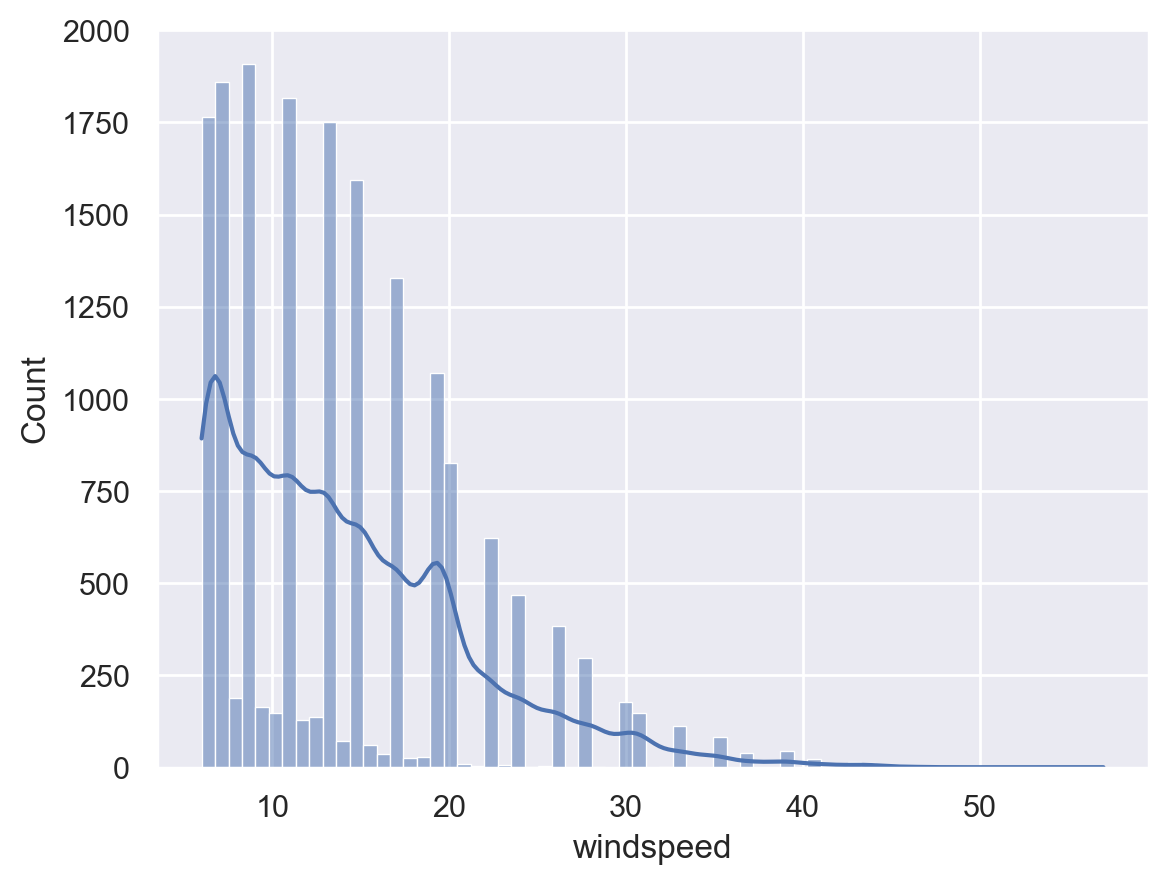

In [77]:
sns.histplot(data['windspeed'], kde=True)

<Axes: xlabel='count', ylabel='Count'>

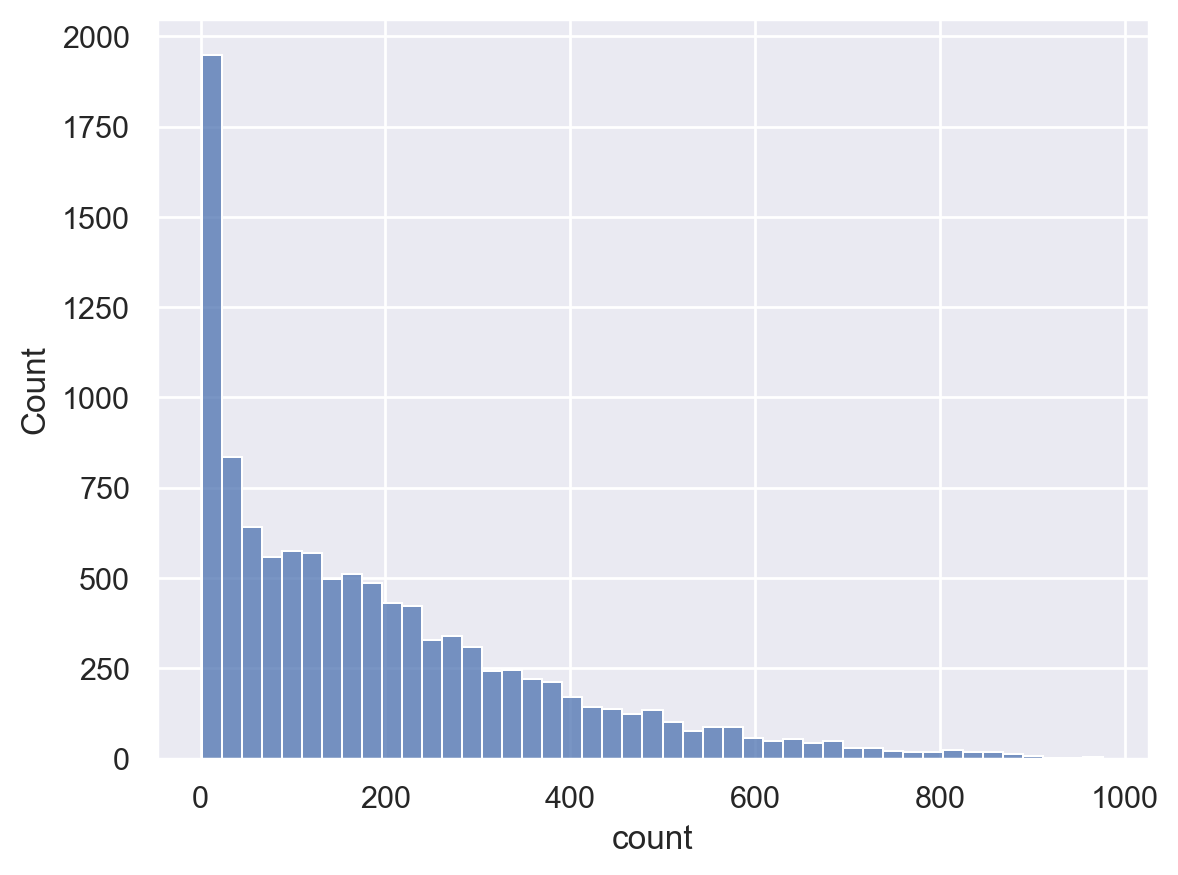

In [83]:
#腳踏車出借數量(count)的資料分佈
sns.histplot(data['count'])